In [33]:

import numpy as np
import torch

import sys
import os
import scipy.io as sio



#print(os.path.dirname(os.path.abspath("")))
#sys.path.append(os.path.dirname(os.path.abspath("")))

cwd = os.getcwd()


#sys.path.append(cwd + '/my_directory')

sys.path.append(cwd)



import matplotlib.pyplot as plt

# General imports
import numpy as np
import torch

# DeePyMoD imports
from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.data.burgers import burgers_delta
from deepymod.model.constraint import LeastSquares, Ridge, STRidgeCons
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.sparse_estimators import Threshold, STRidge
from deepymod.training import train
#from deepymod.training.training_2 import train

from deepymod.training.sparsity_scheduler import Periodic, TrainTest, TrainTestPeriodic

#from deepymod.data.data_set_preparation import DatasetPDE, pde_data_loader

import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.io import loadmat



if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(50)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



cuda


In [34]:

def create_data():
    data = loadmat("data/AC.mat")
    
    data = scipy.io.loadmat("data/AC.mat")

    ## preparing and normalizing the input and output data
    t = data["tt"].flatten()[0:201, None]
    x = data["x"].flatten()[:, None]
    Exact = np.real(data["uu"])
    X, T = np.meshgrid(x, t, indexing="ij")
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = Exact.flatten()[:, None]
    
    #coords = torch.from_numpy(np.stack((t,x), axis=-1))
    #data = torch.from_numpy(np.real(data["uu"])).unsqueeze(-1)
    # alternative way of providing the coordinates
    # coords = torch.from_numpy(np.transpose((t_v.flatten(), x_v.flatten(), y_v.flatten())))
    # data = torch.from_numpy(usol[:, :, :, 3].reshape(-1,1))
    print("The coodinates have shape {}".format(X_star.shape))
    print("The data has shape {}".format(u_star.shape))
    
    X_star = torch.tensor(X_star, dtype= float, )
    u_star = torch.tensor(u_star, dtype= float,)
    
    return X_star, u_star


The coodinates have shape (102912, 2)
The data has shape (102912, 1)
Dataset is using device:  cuda


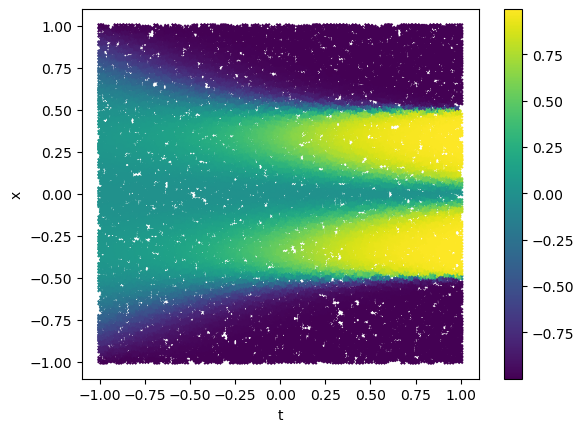

In [35]:


dataset = Dataset(
    create_data,
    preprocess_kwargs={
        "noise_level": 0.00,
        "normalize_coords": True,
        "normalize_data": False,
    },
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 20000},
    device=device,)




coords = dataset.get_coords().detach().cpu()
data = dataset.get_data().detach().cpu()

fig, ax = plt.subplots()
im = ax.scatter(coords[:,1], coords[:,0], c=data[:,0], marker="x", s=10)
ax.set_xlabel('t')
ax.set_ylabel('x')
fig.colorbar(mappable=im)

plt.show()

train_dataloader, test_dataloader = get_train_test_loader(
    dataset, train_test_split=0.8)

##########################
##########################

poly_order = 3
diff_order = 2
n_combinations = (poly_order+1)*(diff_order+1) 
n_features = 1

network = NN(2, [64, 64, 64, 64], 1)

library = Library1D(poly_order, diff_order)
estimator = Threshold(0.0005) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)
constraint = LeastSquares()
constraint_2 = Ridge()
constraint_3 = STRidgeCons()

estimator_2 = STRidge()

#linear_module = CoeffsNetwork(int(n_combinations),int(n_features))

#constraint = Ridge()
# Configuration of the sparsity scheduler
model = DeepMoD(network, library, estimator_2, constraint_2, estimator_2).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 



In [36]:

for i in range(50):

    train(
        model,
        train_dataloader,
        test_dataloader,
        optimizer,
        sparsity_scheduler,
        exp_ID="Test",
        write_iterations=25,
        max_iterations=25000,
        delta=1e-4,
        patience=200,)
    

    dataset = Dataset(
    create_data,
    preprocess_kwargs={
        "noise_level": 0.00,
        "normalize_coords": True,
        "normalize_data": False,
        },
        subsampler=Subsample_random,
        subsampler_kwargs={"number_of_samples": 2000},
        device=device,)
    
    train_dataloader, test_dataloader = get_train_test_loader(
    dataset, train_test_split=0.8)
    
    
    if i < 50:
        model.func_approx.load_state_dict(model.func_approx.state_dict())

    
    
    print(model.estimator_coeffs())





 22350  MSE: 6.50e-03  Reg: 4.58e-04  L1: 2.72e+00 Algorithm converged. Writing model to disk.
The coodinates have shape (102912, 2)
The data has shape (102912, 1)
Dataset is using device:  cuda
[tensor([[  0.0000],
        [  2.6412],
        [-43.0317],
        [ -6.1531],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]
 24975  MSE: 4.89e-03  Reg: 3.98e-04  L1: 2.85e+00 Algorithm converged. Writing model to disk.
The coodinates have shape (102912, 2)
The data has shape (102912, 1)
Dataset is using device:  cuda
[tensor([[  0.0000],
        [  3.4465],
        [-34.3345],
        [ -6.8432],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]
 16150  MSE: 5.01e-03 

 17500  MSE: 4.52e-03  Reg: 3.36e-04  L1: 2.56e+00 Algorithm converged. Writing model to disk.
The coodinates have shape (102912, 2)
The data has shape (102912, 1)
Dataset is using device:  cuda
[tensor([[  0.0000],
        [  4.5266],
        [-25.9090],
        [ -6.8908],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]
 18500  MSE: 4.28e-03  Reg: 2.97e-04  L1: 2.99e+00 Algorithm converged. Writing model to disk.
The coodinates have shape (102912, 2)
The data has shape (102912, 1)
Dataset is using device:  cuda
[tensor([[  0.0000],
        [  5.9934],
        [-25.5570],
        [ -6.1337],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]
  2000  MSE: 4.49e-03 

 19100  MSE: 4.75e-03  Reg: 3.67e-04  L1: 2.95e+00 Algorithm converged. Writing model to disk.
The coodinates have shape (102912, 2)
The data has shape (102912, 1)
Dataset is using device:  cuda
[tensor([[  0.0000],
        [  6.2422],
        [-25.4414],
        [ -7.0221],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]
 21125  MSE: 4.56e-03  Reg: 3.32e-04  L1: 2.94e+00 Algorithm converged. Writing model to disk.
The coodinates have shape (102912, 2)
The data has shape (102912, 1)
Dataset is using device:  cuda
[tensor([[  0.0000],
        [  5.7659],
        [-25.7027],
        [ -6.8770],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]
  6650  MSE: 4.42e-03 

(512, 201)
(512, 512)
(201, 201)
(201,)
(512, 201)
The coodinates have shape (102912, 2)
The data has shape (102912, 1)
The coodinates have shape (102912, 2)
The data has shape (102912, 1)


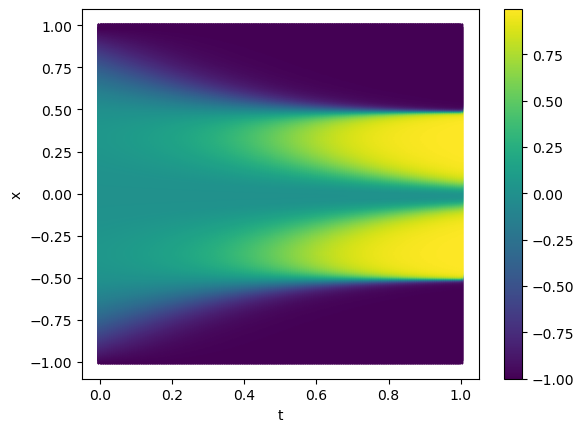

In [5]:
data = loadmat("data/AC.mat")
data = scipy.io.loadmat("data/AC.mat")

t = data["tt"].flatten()[0:201, None]
x = data["x"].flatten()[:, None]
Exact = np.real(data["uu"])


print(Exact.shape)

U, s, VT = np.linalg.svd(Exact)

print(U.shape)
print(VT.shape)
print(s.shape)


rec_u = U[:, :11] @ np.diag(s[:11]) @ VT[:11, :]

print(rec_u.shape)

rec_u_f = rec_u.flatten()[:, None]


x_t, u = create_data()

x_t = x_t.detach().cpu().numpy()
u = u.detach().cpu().numpy()


x_t, u = create_data()

x_t = x_t.detach().cpu().numpy()
u = u.detach().cpu().numpy()
fig, ax = plt.subplots()
im = ax.scatter(x_t[:,1], x_t[:,0], c=rec_u_f[:,0], marker="x", s=10)
ax.set_xlabel('t')
ax.set_ylabel('x')
fig.colorbar(mappable=im)




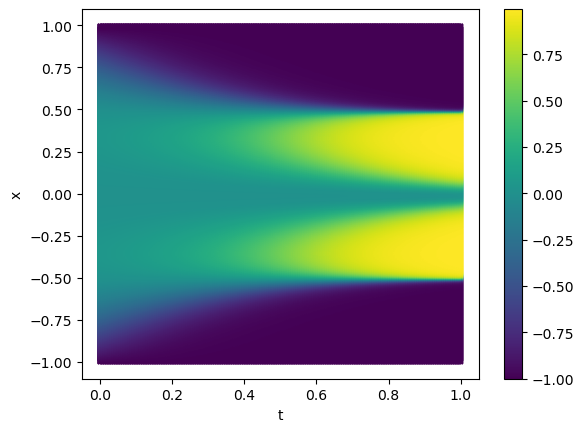

In [7]:

fig, ax = plt.subplots()
im = ax.scatter(x_t[:,1], x_t[:,0], c=u[:,0], marker="x", s=10)
ax.set_xlabel('t')
ax.set_ylabel('x')
fig.colorbar(mappable=im)

In [12]:

U, s, VT = np.linalg.svd(Exact)

rec_u = U[:, :11] @ np.diag(s[:11]) @ VT[:11, :]

print(U.shape)
print(VT.shape)
print(s.shape)

print(np.diag(s[:11]) @ VT[:11, :])

xyz = np.diag(s[:11]) @ VT[:11, :]

print(xyz.shape)


xyzd = U[:, :11] @ xyz

print(xyzd.shape)


(512, 512)
(201, 201)
(201,)
[[ 6.87785096e+00  6.96625703e+00  7.05486456e+00 ...  2.03718749e+01
   2.03849738e+01  2.03976728e+01]
 [-4.59602834e+00 -4.63280744e+00 -4.66884034e+00 ...  5.18163954e+00
   5.20699858e+00  5.23167230e+00]
 [-1.90632581e+00 -1.89468198e+00 -1.88199911e+00 ... -1.76214017e+00
  -1.79420122e+00 -1.82569116e+00]
 ...
 [ 1.86942184e-02  1.47664334e-02  1.11558078e-02 ...  9.77594580e-03
   1.29700735e-02  1.64558446e-02]
 [ 7.63253066e-03  5.59204323e-03  3.77845609e-03 ... -4.09671360e-03
  -6.04789019e-03 -8.24494180e-03]
 [ 3.82229385e-03  2.55989058e-03  1.48092093e-03 ...  1.35848163e-03
   2.31656971e-03  3.43304824e-03]]
(11, 201)
(512, 201)


In [15]:
import numpy as np
from scipy.linalg import svd, rq

def cur_decomposition(M, k):
    # Perform SVD on the original matrix M
    U, s, VT = svd(M, full_matrices=False)
    
    # Select the top k singular values/vectors
    U_k = U[:, :k]
    s_k = np.diag(s[:k])
    VT_k = VT[:k, :]
    
    # Compute the CUR decomposition
    C = U_k
    U_cur = s_k @ VT_k
    R = rq(U_cur, mode='economic')[1]
    
    return C, U_cur, R

# Example usage
# Generate a random matrix M


# Perform CUR decomposition with k=10
C, U_cur, R = cur_decomposition(Exact, k=11)

print(C.shape)

print(U_cur.shape)


print(R.shape)




# Reconstruct the original matrix
#M_reconstructed = C @ U_cur @ R

# Check the reconstruction error
#reconstruction_error = np.linalg.norm(M - M_reconstructed)

#print("Reconstruction error:", reconstruction_error)


(512, 11)
(11, 201)
(11, 201)
